In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from time import time

from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Exploring the Data

변수 타입 및 null check

In [40]:
path = 'E:\\unist\\skt\\'
data = pd.read_csv(path+'loan.csv')
print(data.columns,'\n', len(data.columns), len(data))
data.head()

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object') 
 13 614


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,Null,NaN,360,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1.0,Urban,Y


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null object
LoanAmount           594 non-null object
Loan_Amount_Term     602 non-null object
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 62.4+ KB


In [41]:
data.dropna(inplace=True)
len(data)

482

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 1 to 613
Data columns (total 13 columns):
Loan_ID              482 non-null object
Gender               482 non-null object
Married              482 non-null object
Dependents           482 non-null object
Education            482 non-null object
Self_Employed        482 non-null object
ApplicantIncome      482 non-null int64
CoapplicantIncome    482 non-null object
LoanAmount           482 non-null object
Loan_Amount_Term     482 non-null object
Credit_History       482 non-null float64
Property_Area        482 non-null object
Loan_Status          482 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 52.7+ KB


In [42]:
data['Dependents'] = data['Dependents'].str.replace('3\+', '3').astype(int)

In [47]:
data = data[data['CoapplicantIncome']!='Null']
data['CoapplicantIncome'] = data['CoapplicantIncome'].astype(float)

In [51]:
data = data[data['LoanAmount']!='Null']
data['LoanAmount'] = data['LoanAmount'].astype(float)

In [52]:
data = data[data['Loan_Amount_Term']!='Null']
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype(float)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 1 to 613
Data columns (total 13 columns):
Loan_ID              478 non-null object
Gender               478 non-null object
Married              478 non-null object
Dependents           478 non-null int32
Education            478 non-null object
Self_Employed        478 non-null object
ApplicantIncome      478 non-null int64
CoapplicantIncome    478 non-null float64
LoanAmount           478 non-null float64
Loan_Amount_Term     478 non-null float64
Credit_History       478 non-null float64
Property_Area        478 non-null object
Loan_Status          478 non-null object
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 50.4+ KB


In [144]:
print(len(data))
data = data.reset_index(drop=True)
data.head()

478


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [79]:
con_var = list(data.columns[data.dtypes != 'object'])
print(con_var)
cat_var = list(data.columns[data.dtypes == 'object'])
print(cat_var)

['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [80]:
cat_var = cat_var[1:]

## 변수 탐색

Y    331
N    147
Name: Loan_Status, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


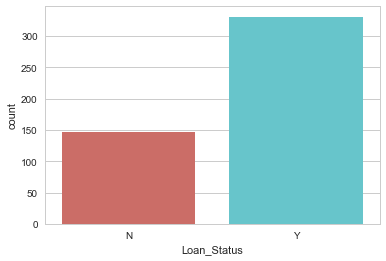

In [138]:
print(data['Loan_Status'].value_counts())
sns.countplot(x='Loan_Status', data=data, palette='hls')

In [59]:
data.groupby('Loan_Status').mean()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,
N,0.727891,5745.292517,1785.142857,153.904762,342.693878,0.578231
Y,0.794562,5195.356495,1500.026949,140.930514,342.561934,0.978852


In [125]:
data.iloc[1:2]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [126]:
data.iloc[6:7]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
7,LP001014,Male,Yes,3,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N


In [111]:
data['Credit_History'].value_counts()

1.0    409
0.0     69
Name: Credit_History, dtype: int64

In [60]:
data.groupby('Loan_Status').median()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,
N,0,3875,0.0,128.0,360.0,1.0
Y,0,3858,1213.0,128.0,360.0,1.0


1. 대출승인을 받지 못한 경우에서 applicant와 coapplicant의 평균 수입이 더 높음
2. 대출승인을 받지 못한 경우 평균 대출액이 더 높음
3. 대출기간은 비슷함
4. credit history에서 가장 큰 차이가 나타남. 높을수록 대출승인 확률 높음

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


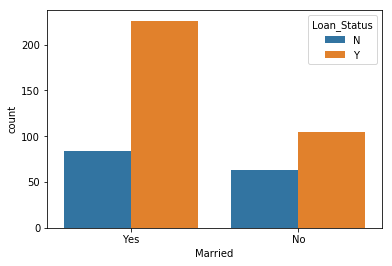

In [104]:
pd.crosstab(data['Loan_Status'], data['Married'], normalize='columns')
sns.countplot('Married', hue='Loan_Status', data=data)

결혼을 한 경우 상대적으로 승인률이 높으나 다른 변수와의 상관성 확인 필요

In [91]:
pd.crosstab(data['Loan_Status'], data['Gender'], normalize='columns')

Gender,Female,Male
Loan_Status,,
N,0.364706,0.295165
Y,0.635294,0.704835


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


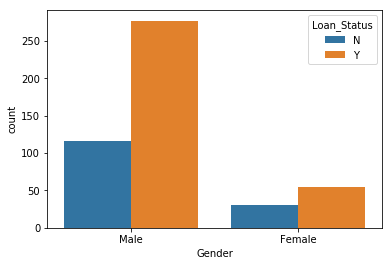

In [103]:
sns.countplot('Gender', hue='Loan_Status', data=data)

큰 차이는 보이지 않으나 남성의 경우 승인률이 조금 더 높음. 마찬가지로 다른 변수와의 상관성 확인 필요

In [93]:
pd.crosstab(data['Loan_Status'], data['Self_Employed'], normalize='columns')

Self_Employed,No,Yes
Loan_Status,,
N,0.300242,0.353846
Y,0.699758,0.646154


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


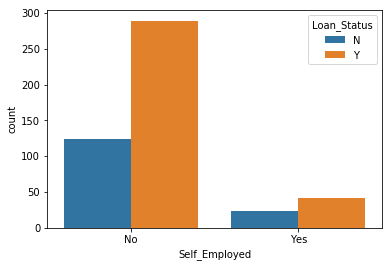

In [105]:
sns.countplot('Self_Employed', hue='Loan_Status', data=data)

In [94]:
pd.crosstab(data['Loan_Status'], data['Education'], normalize='columns')

Education,Graduate,Not Graduate
Loan_Status,,
N,0.290576,0.375
Y,0.709424,0.625


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


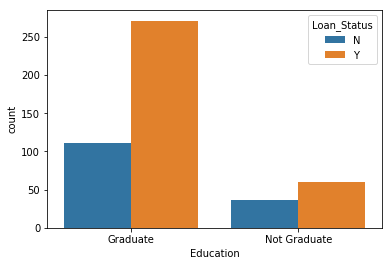

In [106]:
sns.countplot('Education', hue='Loan_Status', data=data)

In [108]:
pd.crosstab(data['Loan_Status'], data['Property_Area'], normalize='columns').reset_index()

Property_Area,Loan_Status,Rural,Semiurban,Urban
0,N,0.388489,0.219895,0.344595
1,Y,0.611511,0.780105,0.655405


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


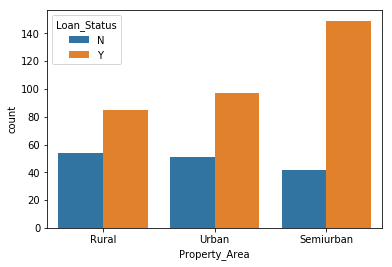

In [109]:
sns.countplot('Property_Area', hue='Loan_Status', data=data)

semiurban일수록 승인율 높음
rural < urban < semiurban

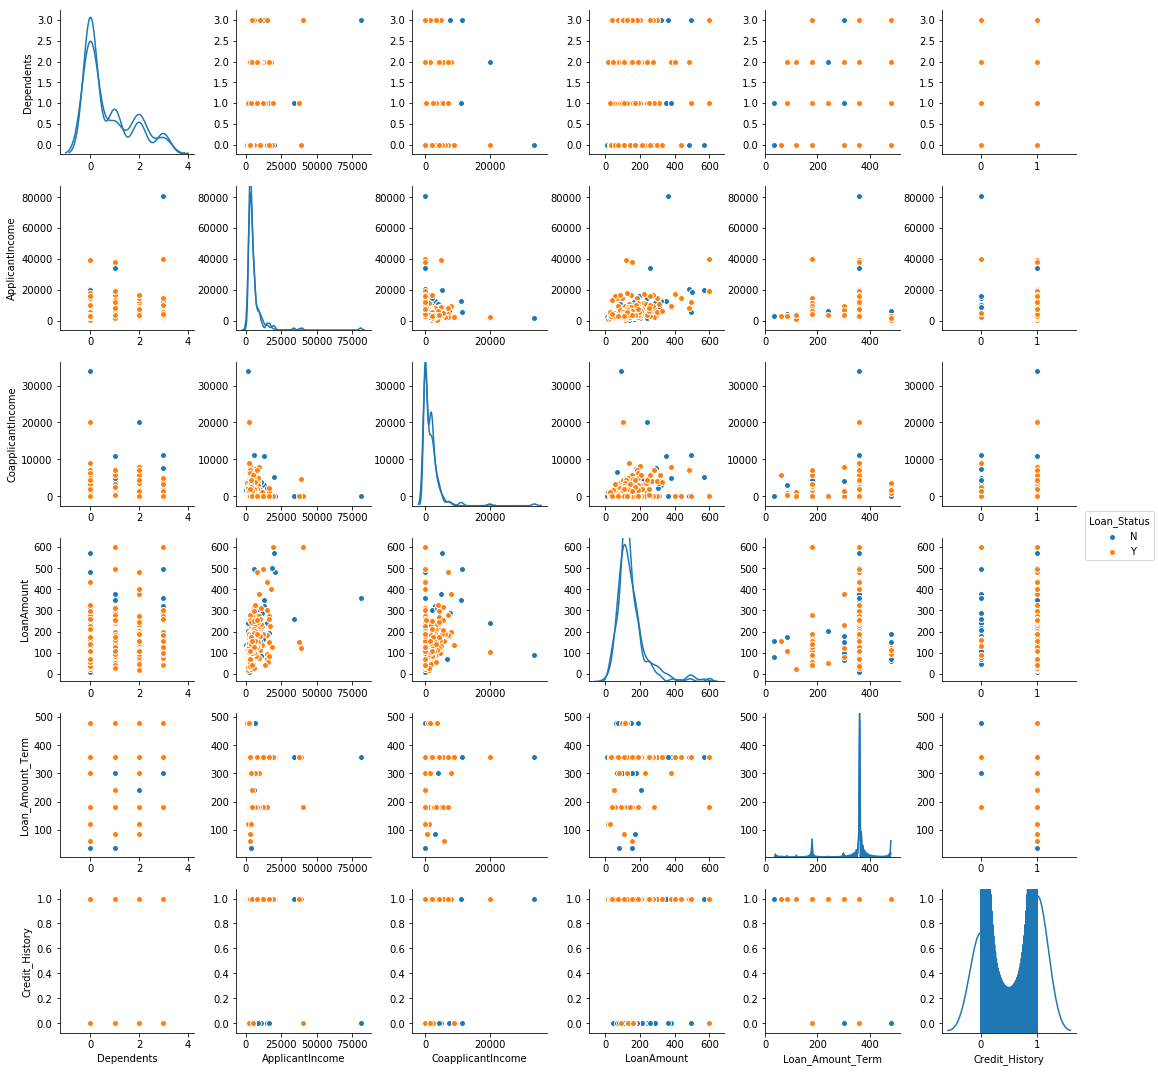

In [110]:
sns.pairplot(data, hue='Loan_Status', diag_kind='kde')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


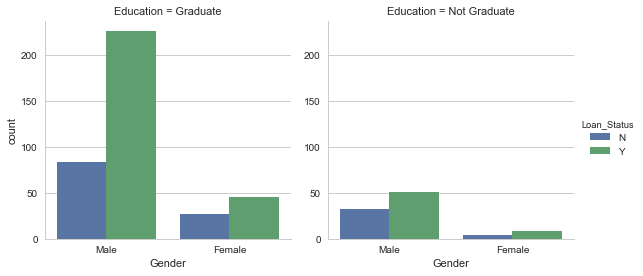

In [117]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", color_codes=True)
sns.factorplot("Gender", col='Education', data=data, hue='Loan_Status', kind="count")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


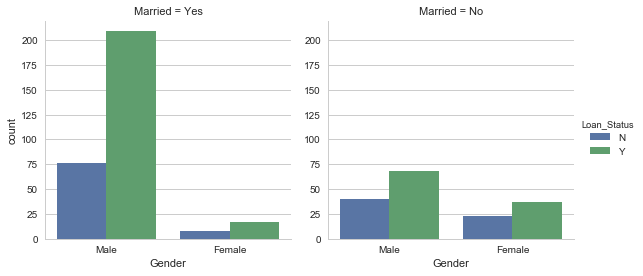

In [118]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", color_codes=True)
sns.factorplot("Gender", col='Married', data=data, hue='Loan_Status', kind="count")
plt.show()

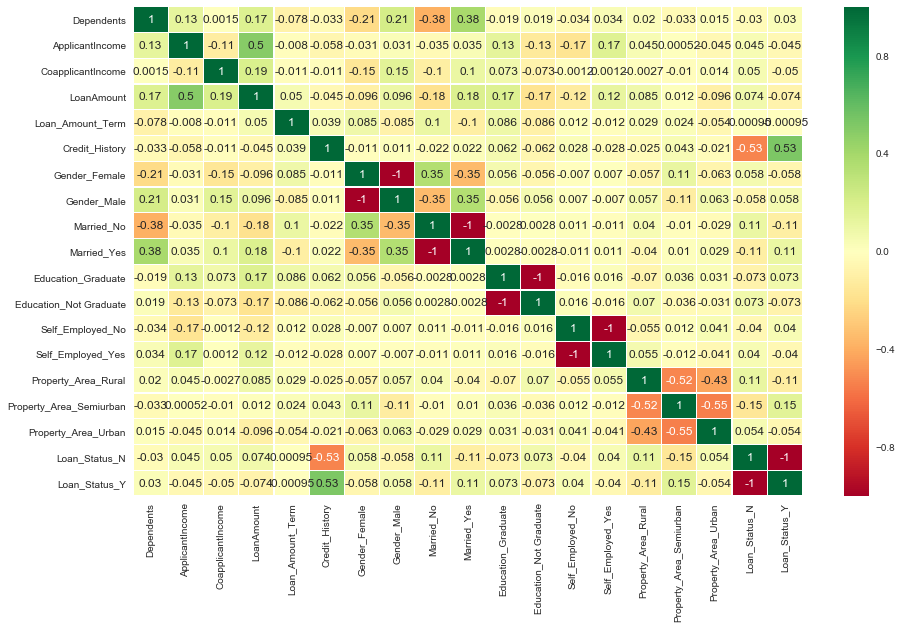

In [136]:
sns.heatmap(DD.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,9)
plt.show()

In [132]:
con = data[con_var]
cat = pd.get_dummies(data[cat_var], prefix=cat_var, drop_first=False)
DD = pd.concat([con, cat], axis=1)
DD.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,1,4583,1508.0,128.0,360.0,1.0,0,1,0,1,1,0,1,0,1,0,0,1,0
2,0,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1,0,1
3,0,2583,2358.0,120.0,360.0,1.0,0,1,0,1,0,1,1,0,0,0,1,0,1
4,0,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,0,1,0,0,0,1,0,1
5,2,5417,4196.0,267.0,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1,0,1


In [128]:
con = data[con_var]
cat = pd.get_dummies(data[cat_var], prefix=cat_var, drop_first=True)
D = pd.concat([con, cat], axis=1)
D.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
1,1,4583,1508.0,128.0,360.0,1.0,1,1,0,0,0,0,0
2,0,3000,0.0,66.0,360.0,1.0,1,1,0,1,0,1,1
3,0,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,1,1
4,0,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,1,1
5,2,5417,4196.0,267.0,360.0,1.0,1,1,0,1,0,1,1


1. Credit_History가 높을수록 대출 승인률 높아짐(상관계수 0.53)
2. 신청자의 소득이 높을수록 대출액 높아짐(상관계수 0.5)
3. 결혼한 사람일수록 대출액 높아짐(상관계수 0.18)
4. 자영업일수록 소득 높음(상관계수 0.17)
5. 남자일수록 coapplicant의 소득 높음(상관계수 0.15)
6. graduate일수록 대출액 높음(상관계수 0.17)

##  
#### 아웃라이어 체크

In [147]:
log_data = data.copy()

In [150]:
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in con_var[1:-1]:
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    out = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(out)
    outliers = outliers + list(out.index.values)
    

#Creating list of more outliers which are the same for multiple features.
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))    

print("Outliers: {}".format(outliers))

# Remove the outliers, if any were specified 
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
print("The good dataset now has {} observations after removing outliers.".format(len(good_data)))

Data points considered outliers for the feature 'ApplicantIncome':


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
8,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
25,LP001100,Male,No,3,Graduate,No,12500,3000.0,320.0,360.0,1.0,Rural,N
40,LP001186,Female,Yes,1,Graduate,Yes,11500,0.0,286.0,360.0,0.0,Urban,N
52,LP001233,Male,Yes,1,Graduate,No,10750,0.0,312.0,360.0,1.0,Urban,Y
81,LP001369,Male,Yes,2,Graduate,No,11417,1126.0,225.0,360.0,1.0,Urban,Y
85,LP001401,Male,Yes,1,Graduate,No,14583,0.0,185.0,180.0,1.0,Rural,Y
88,LP001422,Female,No,0,Graduate,No,10408,0.0,259.0,360.0,1.0,Urban,Y
93,LP001451,Male,Yes,1,Graduate,Yes,10513,3850.0,160.0,180.0,0.0,Urban,N
101,LP001492,Male,No,0,Graduate,No,14999,0.0,242.0,360.0,0.0,Semiurban,N
107,LP001508,Male,Yes,2,Graduate,No,11757,0.0,187.0,180.0,1.0,Urban,Y


Data points considered outliers for the feature 'CoapplicantIncome':


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
8,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
10,LP001028,Male,Yes,2,Graduate,No,3073,8106.0,200.0,360.0,1.0,Urban,Y
27,LP001114,Male,No,0,Graduate,No,4166,7210.0,184.0,360.0,1.0,Urban,Y
70,LP001318,Male,Yes,2,Graduate,No,6250,5654.0,188.0,180.0,1.0,Semiurban,Y
90,LP001431,Female,No,0,Graduate,No,2137,8980.0,137.0,360.0,0.0,Semiurban,Y
98,LP001488,Male,Yes,3,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban,N
135,LP001610,Male,Yes,3,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
138,LP001633,Male,Yes,1,Graduate,No,6400,7250.0,180.0,360.0,0.0,Urban,N
185,LP001806,Male,No,0,Graduate,No,2965,5701.0,155.0,60.0,1.0,Urban,Y
196,LP001843,Male,Yes,1,Not Graduate,No,2661,7101.0,279.0,180.0,1.0,Semiurban,Y


Data points considered outliers for the feature 'LoanAmount':


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
8,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
16,LP001046,Male,Yes,1,Graduate,No,5955,5625.0,315.0,360.0,1.0,Urban,Y
25,LP001100,Male,No,3,Graduate,No,12500,3000.0,320.0,360.0,1.0,Rural,N
40,LP001186,Female,Yes,1,Graduate,Yes,11500,0.0,286.0,360.0,0.0,Urban,N
52,LP001233,Male,Yes,1,Graduate,No,10750,0.0,312.0,360.0,1.0,Urban,Y
98,LP001488,Male,Yes,3,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban,N
118,LP001536,Male,Yes,3,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
135,LP001610,Male,Yes,3,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
178,LP001776,Female,No,0,Graduate,No,8333,0.0,280.0,360.0,1.0,Semiurban,Y
196,LP001843,Male,Yes,1,Not Graduate,No,2661,7101.0,279.0,180.0,1.0,Semiurban,Y


Data points considered outliers for the feature 'Loan_Amount_Term':


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
12,LP001030,Male,Yes,2,Graduate,No,1299,1086.0,17.0,120.0,1.0,Urban,Y
48,LP001207,Male,Yes,0,Not Graduate,Yes,2609,3449.0,165.0,180.0,0.0,Rural,N
51,LP001228,Male,No,0,Not Graduate,No,3200,2254.0,126.0,180.0,0.0,Urban,N
56,LP001248,Male,No,0,Graduate,No,3500,0.0,81.0,300.0,1.0,Semiurban,Y
58,LP001255,Male,No,0,Graduate,No,3750,0.0,113.0,480.0,1.0,Urban,N
61,LP001263,Male,Yes,3,Graduate,No,3167,4000.0,180.0,300.0,0.0,Semiurban,N
64,LP001275,Male,Yes,1,Graduate,No,3988,0.0,50.0,240.0,1.0,Urban,Y
70,LP001318,Male,Yes,2,Graduate,No,6250,5654.0,188.0,180.0,1.0,Semiurban,Y
73,LP001325,Male,No,0,Not Graduate,No,3620,0.0,25.0,120.0,1.0,Semiurban,Y
76,LP001334,Male,Yes,0,Not Graduate,No,4188,0.0,115.0,180.0,1.0,Semiurban,Y


Outliers: [135, 8, 398, 407, 408, 25, 284, 287, 40, 52, 436, 185, 317, 196, 70, 201, 85, 469, 218, 93, 98, 107, 242, 118, 378, 251]
The good dataset now has 452 observations after removing outliers.


In [151]:
data[data['Property_Area']=='Semiurban'].describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.732984,5368.068063,1554.324607,146.057592,344.481675,0.874346
std,1.008861,5649.111499,2393.857937,84.362762,64.958760,0.332331
min,0.000000,1500.000000,0.000000,25.000000,36.000000,0.000000
25%,0.000000,2840.500000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3859.000000,913.000000,127.000000,360.000000,1.000000
75%,1.000000,5376.500000,2236.500000,171.000000,360.000000,1.000000
max,3.000000,39999.000000,20000.000000,600.000000,480.000000,1.000000


In [153]:
data[data['pro']=='Rural'].describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,0.805755,5764.697842,1576.583597,155.640288,345.496403,0.841727
std,1.109104,7326.415997,1720.376668,84.567785,54.542680,0.366317
min,0.000000,150.000000,0.000000,40.000000,84.000000,0.000000
25%,0.000000,2967.500000,0.000000,110.000000,360.000000,1.000000
50%,0.000000,4106.000000,1447.000000,133.000000,360.000000,1.000000
75%,2.000000,6233.000000,2451.000000,172.500000,360.000000,1.000000
max,3.000000,81000.000000,7873.000000,570.000000,480.000000,1.000000
